# Get data

In [1]:
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import TruncatedSVD

import my_utils
import gzip

In [ ]:
input_gz_file = '../Output/GSE185948_count_RNA.rds.gz'
output_rds_file = '../Output/data_for_r.rds'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_rds_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_rds_file}.')

In [ ]:
import gzip
import shutil

input_gz_file = '../Output/GSE185948_metadata_RNA.csv.gz'
output_csv_file = '../Output/uncompressed_metadata.csv'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_csv_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_csv_file}.')

In [ ]:
output_path = '../Output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [2]:
metadata = pd.read_csv('../Output/uncompressed_metadata.csv')

R code below

## Data Preparation

In [ ]:
#pip install memory_profiler

In [3]:
data_path = '../Output/non_zero.parquet'
row_info_path = '../Output/row_names.csv'
column_info_path = '../Output/col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix, column_names, row_names, row_indices= my_utils.load_data(data_path, row_info_path, column_info_path)

Returning sparse_matrix, column_names, row_names, and row_indices


In [4]:
sparse_matrix

<27970x102710 sparse matrix of type '<class 'numpy.float64'>'
	with 210532923 stored elements in COOrdinate format>

In [5]:
split_pipeline = Pipeline([
    ('splitter', my_utils.SparseTrainTestSplit(test_size=0.2, random_state=42, row_indices = row_indices)),
    # Add other steps in the pipeline as needed
])

# Fit and transform the pipeline
sparse_train, sparse_test, train_indices, test_indices = split_pipeline.fit_transform(sparse_matrix)


In [6]:
sparse_train

<22376x102710 sparse matrix of type '<class 'numpy.float64'>'
	with 166800133 stored elements in COOrdinate format>

In [7]:
clean_and_pca_pipeline = Pipeline([
    ('cleaner', my_utils.DataClean()),  # CleanData is performed first
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=2))
])

# Fit the pipeline to training
clean_and_pca_pipeline.fit(sparse_train)
# Transform the training data
pca_sparse_train = clean_and_pca_pipeline.transform(sparse_train)

pca_sparse_test = clean_and_pca_pipeline.transform(sparse_test)

In [8]:
reindexer = my_utils.Reindex(columns=["PC1", "PC2"], names=row_names, output_folder="../Output")
train_pca_df = reindexer.transform(pca_sparse_train, train_indices, "train")
test_pca_df = reindexer.transform(pca_sparse_test, test_indices, "test")

Box Plot and Scatterplot of Data Set with Outliers


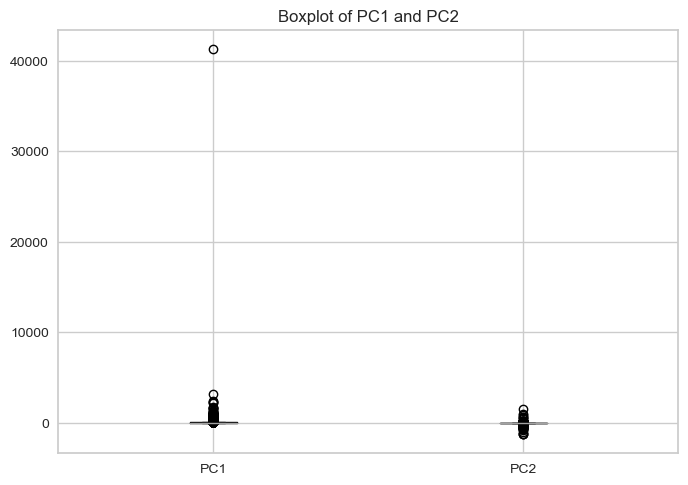

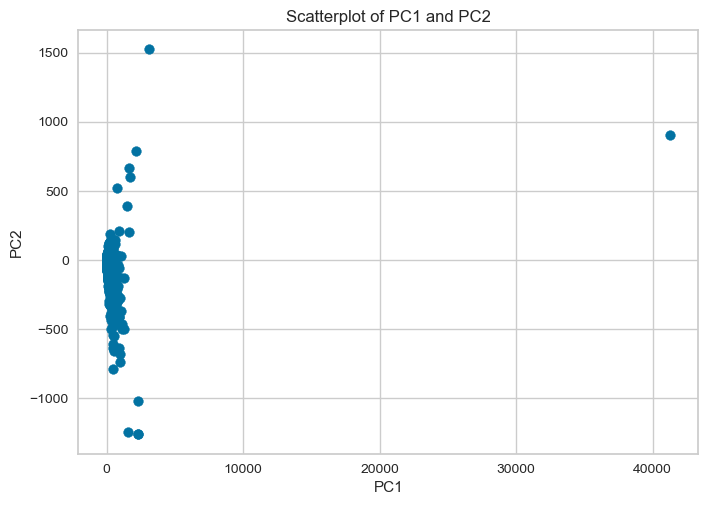

DataFrame of Z-scores sent to output folder
Z-threshold: 10
Df of Outliers sent to output folder
Removing 39 from our dataframe as they exceed our threshold of abs10
Sending updated Df to Output
Box Plot and Scatterplot of Data Set without Outliers


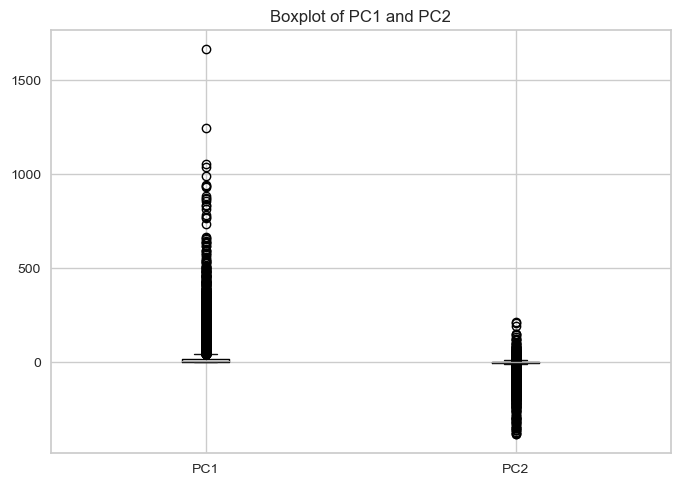

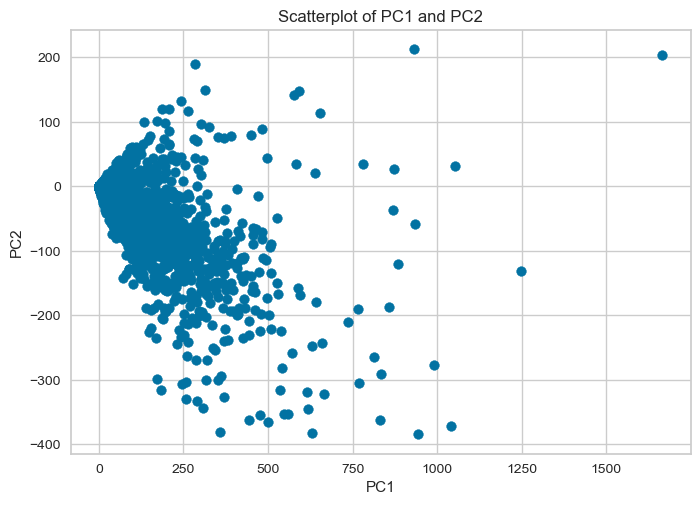

Returning updated dataframe, metadata of rows we removed, and PC of rows we removed


In [9]:
eda_pca = my_utils.DataEDAPCA(columns=["PC1", "PC2"])
updated_train_pca_df, metadata_empty, outlier_df = eda_pca.fit_transform(train_pca_df)

## Clustering on the Train Data

In [ ]:
def optimize_and_compare_kmeans(data, kmeans_params, alpha=0.05):
    # Perform Grid Search
    grid = GridSearchCV(KMeans(), kmeans_params, cv=3, refit=True)
    grid.fit(data)
    grid_search_estimator = grid.best_estimator_

    # Calculate silhouette scores
    default_kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data)
    default_silhouette_score = silhouette_score(data, default_kmeans.labels_)
    grid_search_silhouette_score = silhouette_score(data, grid_search_estimator.labels_)

    # Perform a two-sample t-test only if Grid Search performs better
    if grid_search_silhouette_score > default_silhouette_score:
        t_stat, p_value = stats.ttest_ind(default_kmeans.labels_, grid_search_estimator.labels_)

        # Set the default choice to "Grid Search Estimator"
        choice = "KMeans Estimator"

        # Output informative print statements
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

        if p_value < alpha:
            choice = "Grid Search Estimator"
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better using a threshold of alpha = .05 .")
            return choice, grid_search_estimator
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement using a threshold of alpha = .05.")
            return choice, default_kmeans
    else:
        choice = "Default Parameter"
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Default Parameter has a higher Silhouette Score.")
        print("Using Default Parameter as it performs better based on Silhouette Score.")
        return choice, default_kmeans

     # Return both choice and the chosen KMeans clusterer


# Usage example with parameters
kmeans_params = {
    'n_clusters': list(range(1, 10)),
    'init': ['random', 'k-means++'],
    'n_init': [1, 5, 10],
    'max_iter': [300],
    'random_state': [0]
}
choice, k_means_estimator = optimize_and_compare_kmeans(train_without_outliers, kmeans_params)

In [ ]:
k_means_estimator

In [ ]:
def find_outliers_in_clusters(data, clusterer, n_neighbors=20, contamination=0.1):
    # Fit the Local Outlier Factor (LOF) model on the data
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(data)

    # Create a DataFrame to store cluster labels and outlier labels
    cluster_outliers = pd.DataFrame({'Cluster': clusterer.labels_, 'Outlier': outliers})

    # Print the number of data points and percentage of outliers in each cluster
    cluster_info = cluster_outliers.groupby('Cluster').agg(DataPoints=('Cluster', 'count'),
                                                          PercentageOutliers=('Outlier', lambda x: (x == -1).mean() * 100))
    print("Cluster Information:")
    print(cluster_info)

    return cluster_outliers

# Example usage:
# Assuming you already have a KMeans clusterer 'chosen_kmeans' from the previous code
outliers_in_clusters = find_outliers_in_clusters(train_without_outliers, k_means_estimator)
outliers_in_clusters



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(8, 6))

# Create a scatter plot to visualize the clustering
sns.scatterplot(x='PC1', y='PC2', data=train_without_outliers, hue=k_means_estimator.labels_, palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [ ]:
from sklearn.cluster import HDBSCAN

In [ ]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) == 1:
        return 0  # Silhouette score is undefined for a single cluster
    return silhouette_score(X, labels)

def optimize_and_compare_hdbscan(data, hdbscan_params, alpha=0.05):
    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=HDBSCAN(min_cluster_size=20),
        param_grid=hdbscan_params,
        scoring=silhouette_scorer,
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(data)
    grid_search_estimator = grid_search.best_estimator_

    # Calculate silhouette scores for the default and grid search estimators
    default_hdbscan = HDBSCAN(min_cluster_size=20).fit(data)
    default_labels = default_hdbscan.labels_
    default_silhouette_score = silhouette_score(data, default_labels)

    grid_search_labels = grid_search_estimator.fit_predict(data)
    grid_search_silhouette_score = silhouette_score(data, grid_search_labels)

    # Check if the grid search estimator has a higher silhouette score
    if grid_search_silhouette_score > default_silhouette_score:
        # Perform a two-sample t-test
        t_stat, p_value = stats.ttest_ind(default_labels, grid_search_labels)

        # Check if the p-value is less than the significance level
        if p_value < alpha:
            choice = "Grid Search Estimator"
        else:
            choice = "Default Parameter"
    else:
        choice = "Default Parameter"

    # Output informative print statements
    print("Default HDBSCAN Silhouette Score:", default_silhouette_score)
    print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

    if grid_search_silhouette_score > default_silhouette_score:
        if p_value < alpha:
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better.")
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement.")
    else:
        print("Default Parameter has a higher silhouette score. No t-test performed.")

    return choice

# Define the parameter grid for HDBSCAN
hdbscan_params = {
    'min_samples': [10, 30, 50, 60, 100],
    'min_cluster_size': [100, 200, 300, 400, 500, 600],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}

# Usage example with parameters
result = optimize_and_compare_hdbscan(train_without_outliers, hdbscan_params)

In [ ]:
result

https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970

Things to consider


1) Get the clustering to work in a pipeline
2) Are these ok default parameters
3) What to do with the test data
4) Should we be using silhoute on grid search or should i be optimizaing it differently
5) Are we normalizing it the right way? Since normalize is working along rows is this dealing with out of domain sampels? Just used standard scalar because no normalizers could work and some of them did along rows
6) Make it so it put things in folders
7) Quality check NAS? How do to this with a sparse matrix
8) Do soemthing like she did in notebook 3 to label the data set
9) Naive classifier and base? 
10) Would k-means be base what is naive?


Transposed Data

Task 2

In [11]:
data_path = '../Output/non_zero.parquet'
row_info_path = '../Output/row_names.csv'
column_info_path = '../Output/col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix_trans, row_names_trans, col_names_trans, row_indices_trans= my_utils.load_data(data_path, row_info_path, column_info_path, transpose = True)

Returning Transposed matrix, row_names of the transposed matrix, col_names of the transposed matrix, and row_indices of transposed matrix


In [12]:
split_pipeline_trans = Pipeline([
    ('splitter', my_utils.SparseTrainTestSplit(
        test_size=0.2,
        random_state=42,
        row_indices=row_indices_trans
    )),
    # Add other steps in the pipeline as needed
])

# Fit and transform the pipeline
(
    sparse_train_trans,
    sparse_test_trans,
    train_indices_trans,
    test_indices_trans
) = split_pipeline_trans.fit_transform(sparse_matrix_trans)

In [13]:
clean_and_pca_pipeline_trans = Pipeline([
    ('cleaner', my_utils.DataClean()),  # CleanData is performed first
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=2))
])

# Fit the pipeline to training
clean_and_pca_pipeline_trans.fit(sparse_train_trans)
# Transform the training data
pca_sparse_train_trans = clean_and_pca_pipeline_trans.transform(sparse_train_trans)
pca_sparse_test_trans= clean_and_pca_pipeline_trans.transform(sparse_test_trans)

In [14]:
reindexer_trans = my_utils.Reindex(columns=["PC1", "PC2"], names=row_names_trans, output_folder="../Output")
train_pca_df_trans = reindexer_trans.transform(pca_sparse_train_trans, train_indices_trans, "train")
test_pca_df_trans = reindexer_trans.transform(pca_sparse_test_trans, test_indices_trans, "test")

In [6]:
train_pca_df_trans

,PC1,PC2
PKD_ACGTAACCACTGCACG-1_6,43.638928,-7.157021
PKD_ACGTCCTAGCTTAGTC-1_2,23.758773,-2.550380
PKD_GCTGCAGCATGTGCTA-1_4,12.348957,-1.158106
Cont_CGAGGCTAGCTGTTAC-1_4,42.945916,10.323705
PKD_CATTGAGGTCCAACGC-1_2,71.610043,-16.754826
...,...,...
PKD_GTGTTAGCACGAAGAC-1_1,18.764182,-0.155380
PKD_TCATTGTTCAGCGCGT-1_6,25.794448,-2.923180
Cont_TGATCAGGTGATTCTG-1_2,76.115795,-17.211605
PKD_AGGCCACCACAACCGC-1_1,14.274719,-1.685335


Box Plot and Scatterplot of Data Set with Outliers


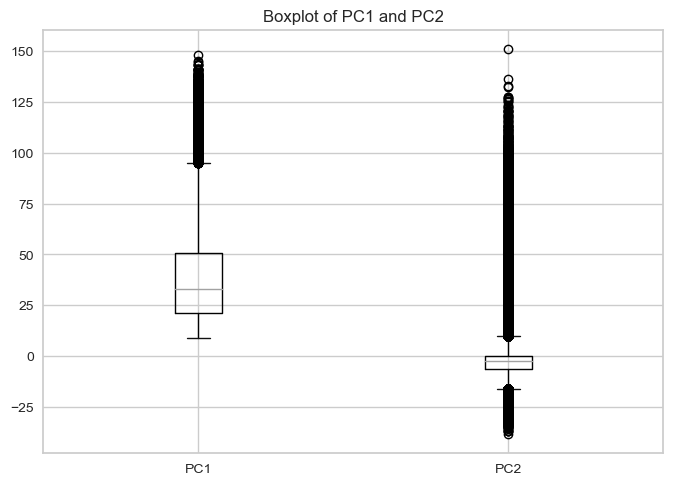

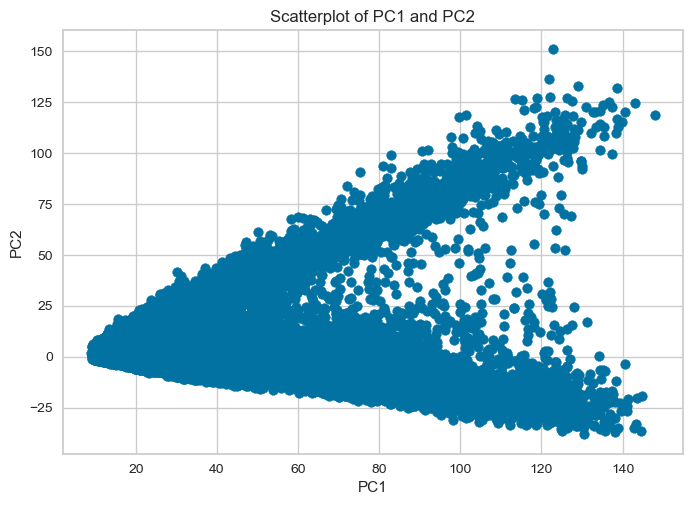

DataFrame of Z-scores sent to output folder
Z-threshold: 10
Df of Outliers sent to output folder
Removing 1 from our dataframe as they exceed our threshold of abs10
Sending updated Df to Output
Box Plot and Scatterplot of Data Set without Outliers


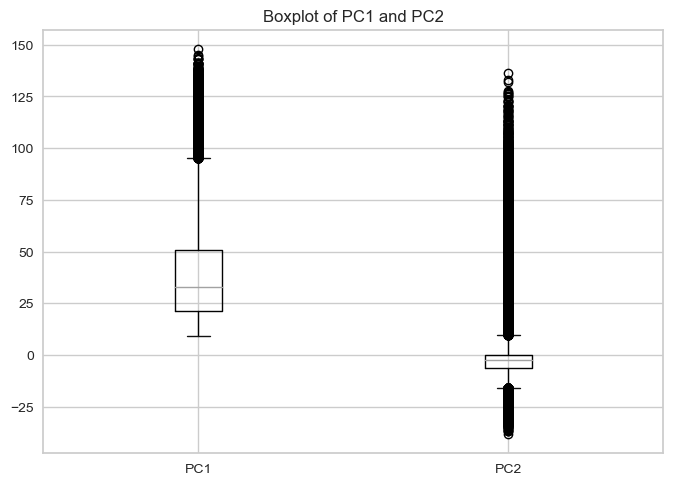

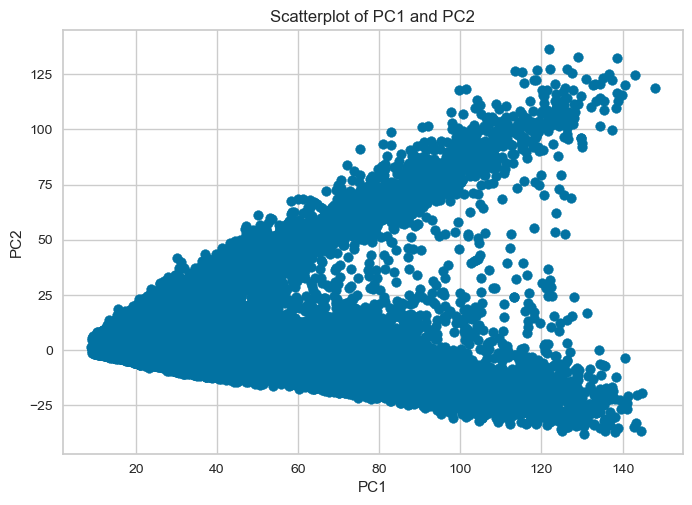

Returning updated dataframe, metadata of rows we removed, and PC of rows we removed


In [15]:
eda_pca = my_utils.DataEDAPCA(columns=["PC1", "PC2"])
updated_train_pca_df_trans, metadata_removed, outlier_df_trans= eda_pca.fit_transform(train_pca_df_trans,another_df=  metadata, trans = "trans")

Clustering on the Transposed Data

In [12]:
import gzip
import os
import shutil
import pandas as pd
from pyarrow.parquet import read_table
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

# You can also define custom functions, classes, and other code in this module.

import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

In [ ]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) == 1:
        return 0  # Silhouette score is undefined for a single cluster
    return silhouette_score(X, labels)

def optimize_and_compare_hdbscan(data, hdbscan_params, alpha=0.05):
    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=HDBSCAN(min_cluster_size=20),
        param_grid=hdbscan_params,
        scoring=silhouette_scorer,
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(data)
    grid_search_estimator = grid_search.best_estimator_

    # Calculate silhouette scores for the default and grid search estimators
    default_hdbscan = HDBSCAN(min_cluster_size=20).fit(data)
    default_labels = default_hdbscan.labels_
    default_silhouette_score = silhouette_score(data, default_labels)

    grid_search_labels = grid_search_estimator.fit_predict(data)
    grid_search_silhouette_score = silhouette_score(data, grid_search_labels)

    # Check if the grid search estimator has a higher silhouette score
    if grid_search_silhouette_score > default_silhouette_score:
        # Perform a two-sample t-test
        t_stat, p_value = stats.ttest_ind(default_labels, grid_search_labels)

        # Check if the p-value is less than the significance level
        if p_value < alpha:
            choice = "Grid Search Estimator"
        else:
            choice = "Default Parameter"
    else:
        choice = "Default Parameter"

    # Output informative print statements
    print("Default HDBSCAN Silhouette Score:", default_silhouette_score)
    print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

    if grid_search_silhouette_score > default_silhouette_score:
        if p_value < alpha:
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better.")
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement.")
    else:
        print("Default Parameter has a higher silhouette score. No t-test performed.")

    return choice

# Define the parameter grid for HDBSCAN
hdbscan_params = {
    'min_samples': [10, 30, 50, 60, 100],
    'min_cluster_size': [100, 200, 300, 400, 500, 600],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}

# Usage example with parameters
result = optimize_and_compare_hdbscan(updated_train_pca_df_trans, hdbscan_params)